# Evaluate CNN Spectrogram Model

## Imports

In [1]:
# Third-Party Libraries
import matplotlib.pyplot as plt
import numpy as np
import torch
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from torch.utils.data import DataLoader
from torchvision import transforms

# Local Modules
from src.__00__paths import docs_dir, figures_dir, model_dir, spectrogram_test_dir
from src.__02__model_creation import Genre_CNN, GenreSpectrogramDataset

## Test GPU

In [2]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

Using device: mps


## Load Model

In [3]:
model = Genre_CNN(num_classes=10).to(device)
model.load_state_dict(torch.load(model_dir / "genre_cnn_model.pth", map_location=device))
model.eval()
print("✔️ Model loaded Successfully.")

✔️ Model loaded Successfully.


## Load Data

In [4]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

test_data = GenreSpectrogramDataset(spectrogram_test_dir, transform=transform)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)
class_names = list(test_data.class_to_idx.keys())

## Predict Outputs

In [5]:
all_preds = []
all_labels = []

with torch.no_grad():
    for X, y in test_loader:
        X, y = X.to(device), y.to(device)
        outputs = model(X)
        preds = outputs.argmax(1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y.cpu().numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

## Evaluate Model

In [6]:
# Compute overall accuracy
acc = (np.array(all_preds) == np.array(all_labels)).mean()
print(f"✔️ Test Accuracy: {acc * 100:.2f}%\n")

report = classification_report(
    all_labels,
    all_preds,
    target_names=class_names,
    zero_division=0  # Prevents warning when a class is not predicted
)

# Print classification report with zero_division fix
with open(docs_dir / "cnn_classification_report.txt", "w") as f:
    f.write(f"Test Accuracy: {acc * 100:.2f}%\n\n")
    f.write("Classification Report:\n")
    f.write(report)
print(f"✔️ Classification Report saved to {'/'.join((docs_dir / 'cnn_classification_report.txt').parts[-3:])}")

✔️ Test Accuracy: 23.33%

✔️ Classification Report saved to outputs/docs/cnn_classification_report.txt


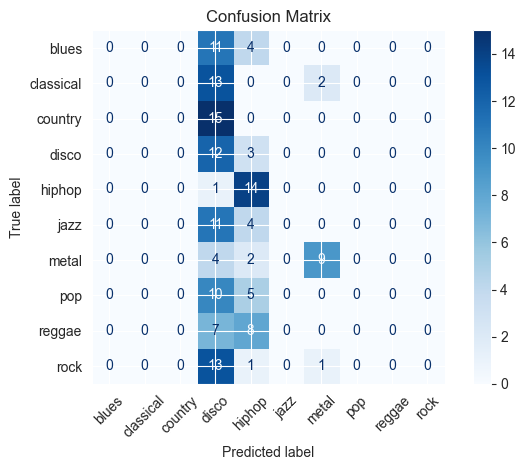

✔️ Confusion Matrix saved to outputs/figures/cnn_confusion_matrix.png


In [7]:
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(xticks_rotation=45, cmap="Blues")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.savefig(figures_dir / "cnn_confusion_matrix.png")
plt.show()
print(f"✔️ Confusion Matrix saved to {'/'.join((figures_dir / 'cnn_confusion_matrix.png').parts[-3:])}")